# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [1]:
import os # for path operations
import time #for time operations
import uuid #for generating unique id
import cv2 #for image operations

In [68]:
IMAGES_PATH = os.path.join('data','images') #we will be putting the images in data/images
number_images = 30 #number of images that we need as samples 

In [ ]:
for image_num in range(30):
    print(image_num)

In [70]:
cap = cv2.VideoCapture(0) # 0 for webcam, 1 for external camera 

#looping through the range of images
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read() #cap is assigned to videoCapture from cv2 -> which is an openCV function
    
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg') #creating a unique name for the image, and joining it with the path
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5) #this gives a bit of time to the camera to adjust to the light

    #to break out of the loop if q is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

: 

### 1.3 Annotate Images with LabelMe

In [6]:
!labelme

2024-01-31 10:16:47,008 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\devin\.labelmerc


# 2. Review Dataset and Build Image Loading Function

1. We're gonna look through collected samples through matpotlib
2. We will be partitioning to training, testintg and validating partitions

### 2.1 Import TF and Deps

In [14]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth -> tensorflow always take maximum vram, to avoid that we set it to limited growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU') #if it does not return an error, it means that the GPU is ready for deep learning

[]

### 2.3 Load Image into TF Data Pipeline

In [6]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [7]:
print(images)

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [8]:
images.as_numpy_iterator().next()

b'data\\images\\5eba6d3c-c0db-11ee-a3cc-70a6ccf719bb.jpg'

In [28]:
def load_image(x): #returns the image in the form of a tensor
    byte_img = tf.io.read_file(x) #taking the file path
    img = tf.io.decode_jpeg(byte_img) #decoding the image
    return img

In [10]:
images = images.map(load_image) 

In [11]:
print(images)

<_MapDataset element_spec=TensorSpec(shape=(None, None, None), dtype=tf.uint8, name=None)>


In [12]:
images.as_numpy_iterator().next()

array([[[199, 199, 199],
        [197, 197, 197],
        [194, 194, 192],
        ...,
        [131, 135, 144],
        [127, 133, 145],
        [129, 135, 147]],

       [[197, 197, 197],
        [198, 198, 198],
        [196, 196, 194],
        ...,
        [128, 132, 141],
        [127, 134, 144],
        [131, 138, 148]],

       [[202, 202, 202],
        [204, 204, 204],
        [202, 202, 200],
        ...,
        [131, 136, 142],
        [132, 137, 143],
        [131, 135, 144]],

       ...,

       [[230, 242, 254],
        [232, 244, 255],
        [228, 240, 252],
        ...,
        [ 17,  17,  25],
        [ 20,  18,  29],
        [ 21,  19,  30]],

       [[228, 240, 254],
        [230, 242, 255],
        [227, 239, 253],
        ...,
        [ 17,  16,  24],
        [ 23,  20,  31],
        [ 24,  21,  32]],

       [[227, 239, 253],
        [229, 241, 255],
        [224, 236, 250],
        ...,
        [ 21,  20,  28],
        [ 25,  22,  33],
        [ 22,  19,  30]]

In [50]:
type(images) #type of images should be a tensorflow data pipeline

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [13]:

image_generator = images.batch(4).as_numpy_iterator() #basically returns a batch of 4 images in one batch

In [14]:
plot_images = image_generator.next()

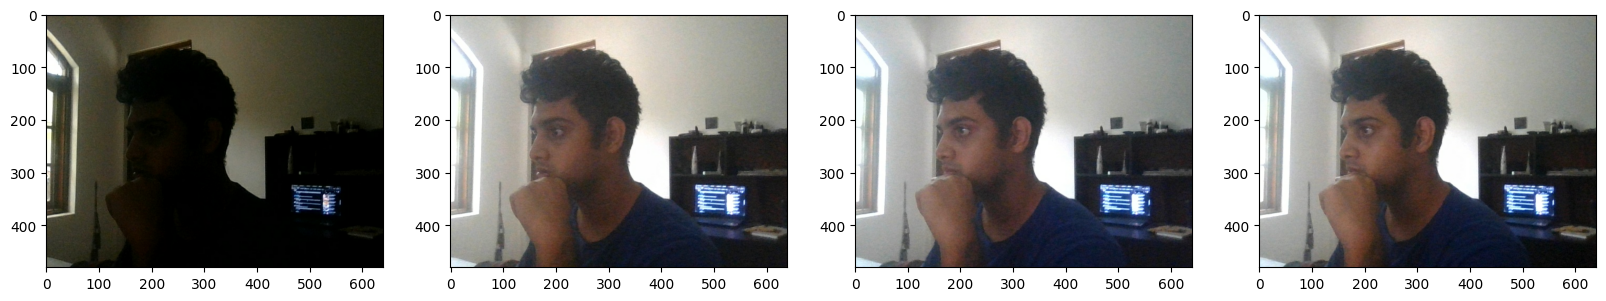

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [63]:
120*.7 # 63 to train

84.0

In [64]:
120*.15 # 18 and 18 to test and val

18.0

In [66]:
(18*2) + 84

120

### 3.2 Move the Matching Labels

In [7]:
#This will move the associated labeled json files to the respective folders, since we manually moved the raw data to the respective environment folders

for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [8]:
import albumentations as alb

In [9]:

#augments the images in different ways, like horizontal flip, vertical flip, random crop, random brightness, random contrast, random gamma, random RGB shift
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [12]:
img = cv2.imread(os.path.join('data','train', 'images','59c65ea2-bf75-11ee-ab8f-70a6ccf719bb.jpg'))
#this is just to load one image and test it out 

In [15]:
with open(os.path.join('data', 'train', 'labels', '59c65ea2-bf75-11ee-ab8f-70a6ccf719bb.json'), 'r') as f:
    label = json.load(f)
    #this is to load the json file associated with the image

In [16]:
print(label)

{'version': '5.4.1', 'flags': {}, 'shapes': [{'label': 'face', 'points': [[148.7878787878788, 94.54545454545453], [330.10101010101016, 315.25252525252523]], 'group_id': None, 'description': '', 'shape_type': 'rectangle', 'flags': {}, 'mask': None}], 'imagePath': '..\\images\\59c65ea2-bf75-11ee-ab8f-70a6ccf719bb.jpg', 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU

In [17]:
label['shapes'][0]['points']

[[148.7878787878788, 94.54545454545453],
 [330.10101010101016, 315.25252525252523]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [18]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [19]:
coords

[148.7878787878788, 94.54545454545453, 330.10101010101016, 315.25252525252523]

In [20]:

#we a re dividing by 640 and 480 because the image is of that size, and we want the coordinates to be in the range of 0 to 1
coords = list(np.divide(coords, [640,480,640,480]))

In [21]:
coords

[0.23248106060606064,
 0.19696969696969693,
 0.5157828282828284,
 0.6567760942760942]

### 4.4 Apply Augmentations and View Results

In [22]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [23]:
augmented['bboxes'][0][2:]

(0.6757800224466892, 0.6961167227833894)

In [24]:
augmented['bboxes']

[(0.2728619528619529,
  0.20565656565656562,
  0.6757800224466892,
  0.6961167227833894)]

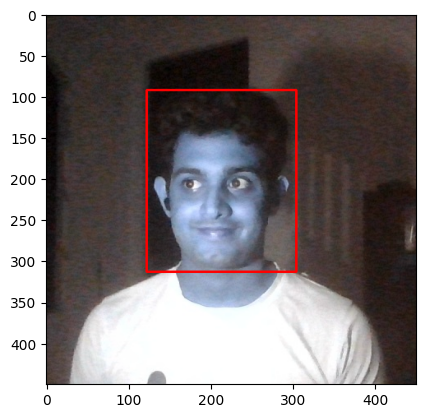

In [25]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [26]:
for partition in ['train','test','val']: #looping within the partitions
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001] #if some images that do not have any faces, we will set the default coordinate as this
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: #like 4th section, we are doing it for 60 images
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [29]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [30]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [31]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [32]:
train_images.as_numpy_iterator().next()

array([[[0.18805148, 0.20471814, 0.17726716],
        [0.19871323, 0.20723039, 0.20588236],
        [0.18020834, 0.18854167, 0.278125  ],
        ...,
        [0.10735294, 0.11519608, 0.09914216],
        [0.09558824, 0.11213236, 0.13290441],
        [0.08020833, 0.09289216, 0.13002451]],

       [[0.17248775, 0.18848039, 0.1911152 ],
        [0.17530638, 0.18241422, 0.18131128],
        [0.15710784, 0.16501226, 0.21531862],
        ...,
        [0.08988971, 0.09675245, 0.09332108],
        [0.09142157, 0.09485294, 0.10171568],
        [0.1086397 , 0.11237745, 0.12708333]],

       [[0.18492647, 0.20582108, 0.25042892],
        [0.1564951 , 0.1682598 , 0.19473039],
        [0.14166667, 0.15735294, 0.2033701 ],
        ...,
        [0.10857843, 0.10857843, 0.11642157],
        [0.11917892, 0.11917892, 0.11231618],
        [0.10919118, 0.11409314, 0.10870098]],

       ...,

       [[0.07457108, 0.08517157, 0.1254902 ],
        [0.07542892, 0.08627451, 0.12432598],
        [0.084375  , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [33]:
def load_labels(label_path): #this is same as load_images
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f) #loading the json file here 
        
    return [label['class']], label['bbox'] #returns two arrays, class and bounding box. Class is the name of the box

### 6.2 Load Labels to Tensorflow Dataset

In [34]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [35]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)



In [36]:
test_labels.as_numpy_iterator().next()

b'aug_data\\test\\labels\\5c8d026a-bf75-11ee-af20-70a6ccf719bb.0.json'

In [37]:
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [38]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)

#there is a bit of a mix up here which is done by the py_function
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [39]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.4197, 0.2023, 0.8237, 0.7163], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [40]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5040, 5040, 1080, 1080, 1080, 1080)

### 7.2 Create Final Datasets (Images/Labels)

In [41]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [42]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [43]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [44]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0]], dtype=uint8),
 array([[0.931 , 0.2435, 1.    , 0.883 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.5464, 0.251 , 0.964 , 0.8345],
        [0.583 , 0.329 , 0.995 , 0.832 ],
        [0.2449, 0.2722, 0.698 , 0.802 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

### 7.3 View Images and Annotations

In [57]:
data_samples = train.as_numpy_iterator()

In [58]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


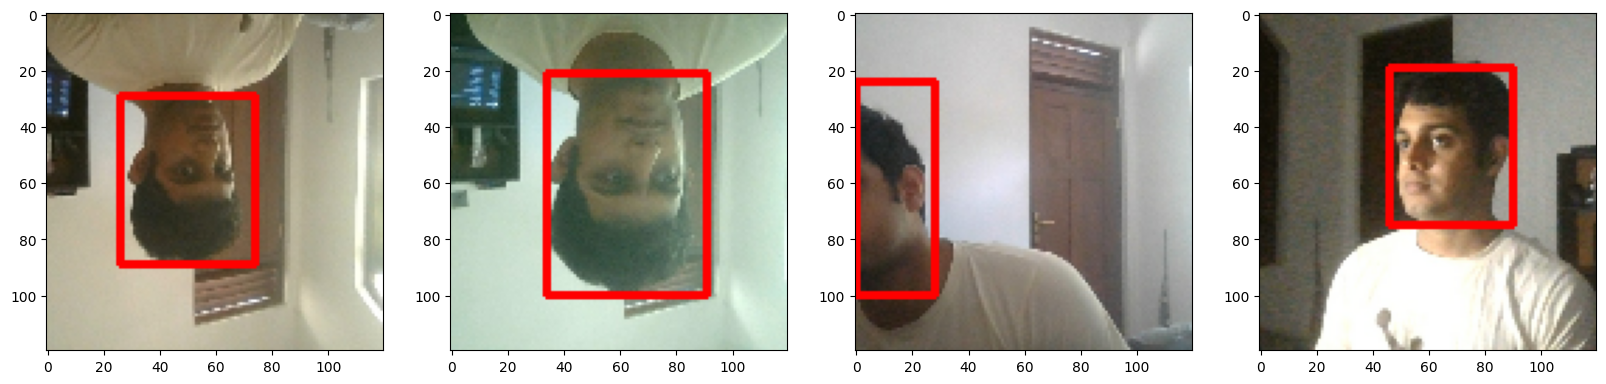

In [59]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    #here in the declaration of the sample_image, it had to be in an np.array
    sample_image = np.array(res[0][idx])
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [3]:
vgg = VGG16(include_top=False)

In [4]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [4]:

def build_model(): 
    
    #when youre creating a neural network, we need to create input layers
    input_layer = Input(shape=(120,120,3)) #120x120x3 pixel input
    
    #we are using the VGG16 model here, and we are using the input layer as the input
    vgg = VGG16(include_top=False)(input_layer)

    #we've mentioned the activation functions here as well
    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [5]:
facetracker = build_model()

In [6]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [45]:
X, y = train.as_numpy_iterator().next()

In [46]:
X.shape

(8, 120, 120, 3)

In [47]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 551ms/step


In [48]:
classes, coords

(array([[0.5334138 ],
        [0.48339194],
        [0.6022883 ],
        [0.53279674],
        [0.5858092 ],
        [0.58109593],
        [0.49796662],
        [0.5082716 ]], dtype=float32),
 array([[0.5254398 , 0.6482486 , 0.32740158, 0.5391909 ],
        [0.39231098, 0.424265  , 0.3665877 , 0.57591903],
        [0.5078527 , 0.6304488 , 0.47415015, 0.4705324 ],
        [0.54088366, 0.6492315 , 0.3217091 , 0.5028036 ],
        [0.5141773 , 0.58282095, 0.37090543, 0.4438579 ],
        [0.56112766, 0.63702595, 0.40372747, 0.47180268],
        [0.5655161 , 0.6940841 , 0.3283339 , 0.5574186 ],
        [0.60004187, 0.64040846, 0.34141815, 0.49189958]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [ ]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [ ]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [ ]:
localization_loss(y[1], coords)

In [ ]:
classloss(y[0], classes)

In [ ]:
regressloss(y[1], coords)

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [ ]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)

In [ ]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

### 10.3 Plot Performance

In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()